Models building

- Retrieve homologous proteins starting from your input sequence performing a BLAST search against UniProt or UniRef50 or UniRef90, or any other database
- Generate a multiple sequence alignment (MSA) starting from retrieved hits using T-coffee or ClustalOmega or MUSCLE
- If necessary, edit the MSA with JalView (or with your custom script or CD-HIT) to remove not conserved positions (columns) and/or redundant information (rows)
- Build a PSSM model starting from the  
psiblast -db uniprot_sprot.fasta -in_msa finalMSA.aln -out_ascii_pssm finalTest.txt -out_pssm FinalTest.pssm
- Build a HMM model starting from the MSA  
hmmbuild finalTest.hmm finalMSA.aln

Build PSSM  
dsf

Models evaluation
1. Generate predictions. Run HMM-SEARCH and PSI-BLAST with your models against SwissProt. 
    - Collect the list of retrieved hits
    - Collect matching positions of your models in the retrieved hits
2. Define your ground truth. Find all proteins in SwissProt annotated (and not annotated) with the assigned Pfam domain
    - Collect the list of proteins matching the assigned Pfam domain
    - Collect matching positions of the Pfam domain in the retrieved sequences. Domain positions are available here (large tsv file) or using the InterPro API or align the Pfam domain yourself against SwissProt (HMMSEARCH)
3. Compare your model with the assigned Pfam. Calculate the precision, recall, F-score, balanced accuracy, MCC
    - Comparison at the protein level. Measure the ability of your model to retrieve the same proteins matched by Pfam
    - Comparison at the residue level. Measure the ability of your model to match the same position matched by Pfam
4. Consider refining your models to improve their performance

UniProt query for SwissProt Entries with Pfam domain
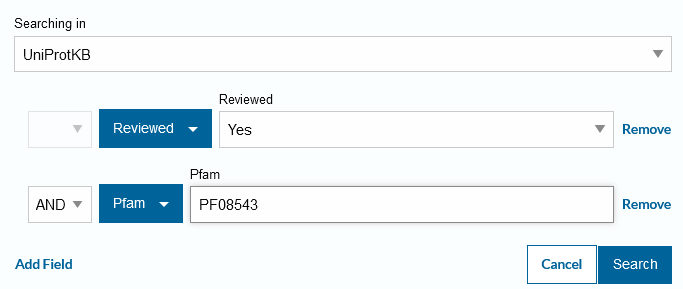
Retruns only 150 proteins
If you use all of uniprot, number is over 60,000

In [111]:
import pandas as pd
import numpy as np

In [99]:
## 1: Generate Predictions
## Code:
## Done by submitting pssm to blast website
## MODEL: PSI-BLAST
## DB - swisprot
# Col names from header in txt results
pssm_col_names = [
    'acc_query',
    'acc_subject',
    '%_identity',
    'alignment_length',
    'mismatches',
    'gap_opens',
    'q_start',
    'q_end',
    's_start',
    's_end',
    'evalue',
    'bit_score',
    '%positives'
]
pssm_hits = pd.read_csv('PSSM-HitTable1.csv', names=pssm_col_names)
pssm_hits['acc'] = pssm_hits['acc_subject'].str.split('.').str[0]
pred_pssm_df = pssm_hits[['acc','alignment_length','q_start','q_end','s_start','s_end']]
pred_pssm_df.sort_values(by='acc')

,acc,alignment_length,q_start,q_end,s_start,s_end
32,A8KRL3,205,481,683,15,216
26,O25515,275,158,426,6,262
13,O31620,255,174,427,20,259
7,O48881,282,155,434,30,299
15,O67772,249,161,408,4,240
33,O83153,263,160,416,4,254
31,O85786,279,157,429,3,260
4,O94265,488,157,630,2,447
3,O94266,549,157,693,35,547
36,P25052,206,481,685,15,216


In [100]:
len('MLGTTDNIAALAEFLRAHPDYQYVLDPVLVANSGGSLGDQATLVKAFVELIPLATLITPNTVELRALTGVTDLDQATQKLFEMGAKAVLVKGGHEDTPDFIKNSLYIDGELAASSTCPRLEGEYHGSGCSLASFIAGRLALGDSLKIAVQHAETWLFGVLKNA')

163

In [101]:
# File is the text output of hmmsearch
# BASH:
# hmmsearch finalTest.hmm swissprot_ftp.fasta > hmm_HitRaw.txt
# contains a lot of information, but we only what the info from the second part, 
# which contains lists of alignments, and will need to be manually pasrsed.
with open('hmm_HitRaw.txt') as f:
    hmmTXT = f.read()

In [102]:
pred_hmm_acc = []
pred_hmm_start = []
pred_hmm_stop = []
pred_hmm_ali_start = []
pred_hmm_ali_stop = []
pred_hmm_env_start = []
pred_hmm_env_stop = []
hmmAlns = str.split(hmmTXT,'>>')[1:]
aln_header = ['score', 'bias', 'c-Evalue', 'i-Evalue', 'hmm_from', 'hmm_to', 'ali_from', 'ali_to', 'env_from', 'env_to', 'acc']
for i, aln in enumerate(hmmAlns):
    aln_lines = str.split(aln,'\n')
    pred_hmm_acc.append(str.split(aln_lines[0],'|')[1])
    aln_vals_raw = str.split(aln_lines[3])[2:]
    aln_vals = aln_vals_raw[0:6]+aln_vals_raw[7:9]+aln_vals_raw[10:12]+aln_vals_raw[13:14]
    pred_hmm_start.append(aln_vals[4])
    pred_hmm_stop.append(aln_vals[5])
    pred_hmm_ali_start.append(aln_vals[6])
    pred_hmm_ali_stop.append(aln_vals[7])
    pred_hmm_env_start.append(aln_vals[8])
    pred_hmm_env_stop.append(aln_vals[9])
    if i==10:
        #DEBUG
        #print(aln_lines[0])
        tst = 10
        #print(aln_header[tst], aln_vals[tst])
pred_hmm_df = pd.DataFrame({
    'acc': pred_hmm_acc,
    'hmm_start': pred_hmm_start,
    'hmm_stop': pred_hmm_stop,
    'ali_start': pred_hmm_ali_start,
    'ali_stop': pred_hmm_ali_stop,
    'env_start': pred_hmm_env_start,
    'env_stop':pred_hmm_env_stop
    })
pred_hmm_df

,acc,hmm_start,hmm_stop,ali_start,ali_stop,env_start,env_stop
0,Q08975,13,529,1,535,1,535
1,Q08224,13,529,1,535,1,535
2,Q5M731,7,523,1,520,1,522
3,O48881,7,525,1,523,1,523
4,Q06490,2,528,12,555,11,556
...,...,...,...,...,...,...,...
945,A9MKV9,164,267,130,229,123,256
946,A0PRY2,357,503,57,204,47,215
947,P33020,154,196,233,274,226,337
948,B8E2P6,234,258,444,468,424,475


In [103]:
# MISTAKE
# downloading results from uniprot only gives 150 proteins
# in reality there are over 60,000
groundTruth_download_df = pd.read_csv('sprot_PHAM_GroundTruth.tsv', sep='\t')
truth_pfam_acc = list(groundTruth_download_df['Entry'])
print(len(truth_pfam_acc))
truth_pfam_acc[0:10]

150


['O00764',
 'O35331',
 'O46560',
 'O48881',
 'P39610',
 'P40191',
 'P61422',
 'P76422',
 'P77150',
 'P82197']

FTP link in doc wrong, correct one is:
ftp://ftp.ebi.ac.uk/pub/databases/interpro/current/protein2ipr.dat.gz
19 Gigabytes! use API instead

In [104]:
import json
import sys
from urllib.error import HTTPError
from urllib.request import urlopen

In [125]:
# Code adaptapted from example on interpro API github
# https://github.com/ProteinsWebTeam/interpro7-api/blob/master/docs/examples/fetch-protein-matches.py
family = 'PF08543'
api_url = "https://www.ebi.ac.uk/interpro/api"

truth_pfam_numFragments = [] # sanity check
truth_pfam_start = []
truth_pfam_stop = []
truth_pfam_len = []
truth_pfam_score = []

# query for each uniprot accention indicated by interpro as having target family
for i, query in enumerate(truth_pfam_acc): 
    url = f"{api_url}/entry/all/protein/UniProt/{query}/"
    url += "?page_size=200&extra_fields=hierarchy,short_name"
    with urlopen(url) as res:
        data = json.loads(res.read().decode("utf-8"))
    for result in data['results']:
        if result['metadata']['accession'] == family:
            fragments = result['proteins'][0]['entry_protein_locations'][0]['fragments']
            numFragments = len(fragments)
            start = fragments[0]['start']
            stop = fragments[0]['end']
            f_len = stop - start
            score = result['proteins'][0]['entry_protein_locations'][0]['score']
            truth_pfam_numFragments.append(numFragments)
            truth_pfam_start.append(start)
            truth_pfam_stop.append(stop)
            truth_pfam_len.append(f_len)
            truth_pfam_score.append(score)
            #DEBUG
            print(query, start, stop, f_len, numFragments, score)
            #print(result['proteins'][0]['entry_protein_locations'][0]['score'])
            #print(result['proteins'][0]['entry_protein_locations'][0]['fragments'])

O00764 94 275 181 1 1.3e-12


KeyboardInterrupt: 

In [59]:
truth_pfam_df['acc'] = truth_pfam_acc
truth_pfam_df

,start,stop,lenght,score,nFragments,acc
0,94,275,181,1.300000e-12,1,O00764
1,94,273,179,2.600000e-13,1,O35331
2,104,284,180,2.900000e-13,1,O46560
3,42,285,243,2.400000e-82,1,O48881
4,13,260,247,3.800000e-86,1,P39610
...,...,...,...,...,...,...
67,78,263,185,1.400000e-08,1,Q9HT57
68,100,270,170,2.200000e-09,1,Q9RYX0
69,23,272,249,2.200000e-80,1,Q9ZBL1
70,20,262,242,1.700000e-86,1,Q9ZBR6


In [50]:
truth_pfam_df = pd.DataFrame({
    'acc': truth_pfam_acc,
    'start': truth_pfam_start,
    'stop': truth_pfam_stop,
    'lenght': truth_pfam_len,
    'score': truth_pfam_score,
    'nFragments': truth_pfam_numFragments
})
truth_pfam_df

,start,stop,lenght,score,nFragments
0,94,275,181,1.300000e-12,1
1,94,273,179,2.600000e-13,1
2,104,284,180,2.900000e-13,1
3,42,285,243,2.400000e-82,1
4,13,260,247,3.800000e-86,1
...,...,...,...,...,...
73,14,262,248,7.600000e-97,1
74,12,258,246,5.900000e-92,1
75,23,268,245,2.900000e-82,1
76,14,260,246,1.900000e-90,1


In [60]:
truth_pfam_df.to_csv('truth_pfam.csv')

# Comparison

In [72]:
print(len(pred_pssm_df))
pred_pssm_df.head()

38


,acc,alignment_length,q_start,q_end,s_start,s_end
0,Q08224,551,135,685,1,551
1,Q08975,551,135,685,1,551
2,Q06490,560,126,685,16,572
3,O94266,549,157,693,35,547
4,O94265,488,157,630,2,447


In [71]:
print(len(truth_pfam_df))
truth_pfam_df.head()

150


,start,stop,lenght,score,nFragments,acc
0,94,275,181,1.300000e-12,1,O00764
1,94,273,179,2.600000e-13,1,O35331
2,104,284,180,2.900000e-13,1,O46560
3,42,285,243,2.400000e-82,1,O48881
4,13,260,247,3.800000e-86,1,P39610


In [77]:
pred_pssm_df[pred_pssm_df['acc'] == 'Q9ZL00']

,acc,alignment_length,q_start,q_end,s_start,s_end
27,Q9ZL00,275,158,426,5,261


PSSM

In [114]:
pssm_eval_df = pd.merge(truth_pfam_df, pred_pssm_df, on='acc', how='outer')
tp_pssm_df = pssm_eval_df[pssm_eval_df['lenght'].notna() & pssm_eval_df['alignment_length'].notna()]
fp_pssm_df = pssm_eval_df[pssm_eval_df['lenght'].isna() & pssm_eval_df['alignment_length'].notna()]
fn_pssm_df = pssm_eval_df[pssm_eval_df['lenght'].notna() & pssm_eval_df['alignment_length'].isna()]
tp_pssm = len(tp_pssm_df)
fp_pssm = len(fp_pssm_df)
fn_pssm = len(fn_pssm_df)
# TN = (len(sprot) - len(positives)) - FN = N - FN
print(np.array([[tp_pssm,fp_pssm],[fn_pssm,0]]))
pssm_eval_df


[[ 34   4]
 [116   0]]


,start,stop,lenght,score,nFragments,acc,alignment_length,q_start,q_end,s_start,s_end
0,94.0,275.0,181.0,1.300000e-12,1.0,O00764,NaN,NaN,NaN,NaN,NaN
1,94.0,273.0,179.0,2.600000e-13,1.0,O35331,NaN,NaN,NaN,NaN,NaN
2,104.0,284.0,180.0,2.900000e-13,1.0,O46560,NaN,NaN,NaN,NaN,NaN
3,42.0,285.0,243.0,2.400000e-82,1.0,O48881,282.0,155.0,434.0,30.0,299.0
4,13.0,260.0,247.0,3.800000e-86,1.0,P39610,257.0,161.0,408.0,7.0,247.0
...,...,...,...,...,...,...,...,...,...,...,...
149,14.0,261.0,247.0,2.500000e-84,1.0,Q9ZL00,275.0,158.0,426.0,5.0,261.0
150,NaN,NaN,NaN,NaN,NaN,Q9K9G8,209.0,474.0,681.0,8.0,214.0
151,NaN,NaN,NaN,NaN,NaN,P44659,208.0,476.0,683.0,8.0,213.0
152,NaN,NaN,NaN,NaN,NaN,A8KRL3,205.0,481.0,683.0,15.0,216.0


HMM

In [105]:
pred_hmm_df.head()

,acc,hmm_start,hmm_stop,ali_start,ali_stop,env_start,env_stop
0,Q08975,13,529,1,535,1,535
1,Q08224,13,529,1,535,1,535
2,Q5M731,7,523,1,520,1,522
3,O48881,7,525,1,523,1,523
4,Q06490,2,528,12,555,11,556


In [115]:
hmm_eval_df = pd.merge(truth_pfam_df, pred_hmm_df, on='acc', how='outer')
tp_hmm_df = hmm_eval_df[hmm_eval_df['lenght'].notna() & hmm_eval_df['ali_start'].notna()]
fp_hmm_df = hmm_eval_df[hmm_eval_df['lenght'].isna() & hmm_eval_df['ali_start'].notna()]
fn_hmm_df = hmm_eval_df[hmm_eval_df['lenght'].notna() & hmm_eval_df['ali_start'].isna()]
tp_hmm = len(tp_hmm_df)
fp_hmm = len(fp_hmm_df)
fn_hmm = len(fn_hmm_df)
print(np.array([[tp_hmm,fp_hmm],[fn_hmm,0]]))

[[150 800]
 [  0   0]]


In [112]:
print(np.array([[tp_hmm,fp_hmm],[fn_hmm,0]]))

[[150 800]
 [  0   0]]


# Taxonomy
Trying to figure out how the api works, lol

In [126]:
query_accs = list(pred_hmm_df['acc'])
for q in query_accs:
    print(q)

Q08975
Q08224
Q5M731
O48881
Q06490
O94266
Q2QWK9
Q8NQH1
Q8FTH8
P61422
P44697
Q6GEY2
Q6G7L7
Q8NVH3
O31620
P66915
P99124
P55882
P76422
P56904
Q9ZBR6
P66914
P9WG76
P9WG77
Q9ZBL1
Q5HI96
Q8CTQ7
Q5HRG7
P39610
O25515
Q9ZL00
O85786
O67772
Q9WZP7
A8A2R4
B1IX53
B1XA89
C4ZVU9
P40191
B7N609
A7ZPL9
B6I4Z5
B7M6S8
B7UGB9
Q3YZC3
B7NPV5
A1ADT5
B7MHS2
B7MY71
Q0TF48
Q1R8V2
Q8FFB5
B2TX08
B7LL66
B5YZW5
Q8XBL0
Q32DD5
B1LML3
B7LCG3
Q83K78
Q8D4Q2
Q7MGA4
A7N5Q6
Q87FP6
Q6LP62
Q66A50
Q1C792
Q1CIM6
Q7CIR8
O94265
O83153
Q7N3W7
O01824
Q51892
Q57PI7
Q8ZPM8
Q1LFU5
Q5PIK8
Q8X649
Q0THJ1
Q1RBF9
Q8FH89
P77150
Q320Z3
Q5PNC8
P40192
Q57LS3
Q83KY1
Q6D5V1
Q9RYX0
Q32FD7
Q3Z1Z2
Q8Z4W1
Q6AFC1
Q1PCB1
B0UUD2
Q0I3D2
Q8W1X2
Q5E345
B3H2H2
A3N2D3
Q141E8
Q65UE8
A5WB73
Q9CNY1
Q88C26
Q2L1P5
Q63SC2
B0KR83
Q1I2L8
A6VNE5
Q0BSF0
Q62LP6
Q3JQA6
Q1J237
Q2SXQ4
A5UA83
Q02DJ3
A6VEZ4
Q1AYE5
Q48BL6
Q9HT57
B1JFM7
Q39I40
B7V753
P44690
Q1BXQ7
C3K4G7
Q6NG19
Q4ZL75
B2JCI0
O35331
O46560
Q3K4B8
Q87TZ6
Q4K3F6
Q0II59
Q9USL6
P82197
Q8K183
Q7W6K7
Q7WII1
Q8Z6Q3

In [156]:
import requests

# URL of the file to be downloaded
url = "https://rest.uniprot.org/uniprotkb/stream?fields=accession%2Creviewed%2Cid%2Cprotein_name%2Cgene_names%2Corganism_name%2Clength%2Cxref_pfam%2Clineage%2Clineage_ids%2Cgo_id%2Cgo_f%2Cgo%2Cgo_c%2Cgo_p&format=tsv&query=%28%28xref%3Apfam-PF08543%29+AND+%28reviewed%3Atrue%29%29"

# Send a GET request to the URL
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Define the local filename to save the content
    filename = "familyInfo_sprot.tsv"
    
    # Open a file in write-binary mode and write the content
    with open(filename, "wb") as file:
        file.write(response.content)
    
    print(f"File downloaded successfully and saved as {filename}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


File downloaded successfully and saved as familyInfo_sprot.tsv


In [159]:
fam_info_df = pd.read_csv('familyInfo_sprot.tsv', sep='\t')
fam_info_df

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Pfam,Taxonomic lineage,Taxonomic lineage (Ids),Gene Ontology IDs,Gene Ontology (molecular function),Gene Ontology (GO),Gene Ontology (cellular component),Gene Ontology (biological process)
0,O00764,reviewed,PDXK_HUMAN,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,PDXK C21orf124 C21orf97 PKH PNK PRED79,Homo sapiens (Human),312,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0000287; GO:0005524; GO:0005576; GO:0005634...,ATP binding [GO:0005524]; lithium ion binding ...,cytosol [GO:0005829]; extracellular exosome [G...,cytosol [GO:0005829]; extracellular exosome [G...,phosphorylation [GO:0016310]; pyridoxal 5'-pho...
1,O35331,reviewed,PDXK_RAT,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,Pdxk Pkh,Rattus norvegicus (Rat),312,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0005524; GO:0005829; GO:0008478; GO:0009410...,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],negative regulation of apoptotic process [GO:0...
2,O46560,reviewed,PDXK_PIG,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,PDXK PKH,Sus scrofa (Pig),322,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0005524; GO:0005829; GO:0008478; GO:0009443...,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; pyridoxal 5'-pho...
3,O48881,reviewed,TPS1_BRANA,Thiamine biosynthetic bifunctional enzyme BTH1...,BTH1,Brassica napus (Rape),523,PF08543;PF02581;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33090 (...",GO:0004789; GO:0005524; GO:0008902; GO:0008972...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,chloroplast [GO:0009507]; ATP binding [GO:0005...,chloroplast [GO:0009507],phosphorylation [GO:0016310]; thiamine biosynt...
4,P39610,reviewed,PDXK_BACSU,Pyridoxine kinase (EC 2.7.1.35) (PN/PL/PM kina...,pdxK ywdB BSU38020 ipa-52r,Bacillus subtilis (strain 168),271,PF08543;,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n...",GO:0005524; GO:0005829; GO:0008478; GO:0008902...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; thiamine biosynt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Q9HT57,reviewed,PDXY_PSEAE,Pyridoxal kinase PdxY (PL kinase) (EC 2.7.1.35),pdxY PA5516,Pseudomonas aeruginosa (strain ATCC 15692 / DS...,288,PF08543;,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1224 (phyl...",GO:0000287; GO:0005524; GO:0005829; GO:0008478...,ATP binding [GO:0005524]; magnesium ion bindin...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; pyridoxal 5'-pho...
146,Q9RYX0,reviewed,PDXY_DEIRA,Pyridoxal kinase PdxY (PL kinase) (EC 2.7.1.35),pdxY DR_A0184,Deinococcus radiodurans (strain ATCC 13939 / D...,298,PF08543;,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n...",GO:0000287; GO:0005524; GO:0005829; GO:0008478...,ATP binding [GO:0005524]; magnesium ion bindin...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; pyridoxal 5'-pho...
147,Q9ZBL1,reviewed,THID_MYCLE,Hydroxymethylpyrimidine/phosphomethylpyrimidin...,thiD ML0295 MLCB1450.27c,Mycobacterium leprae (strain TN),279,PF08543;,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n...",GO:0005524; GO:0008902; GO:0008972; GO:0009228...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,ATP binding [GO:0005524]; hydroxymeth

In [162]:
tax_lineage_df = fam_info_df[['Entry', 'Taxonomic lineage', 'Taxonomic lineage (Ids)']]
tax_lineage_df = tax_lineage_df.rename(columns={
    'Entry': 'acc',
    'Taxonomic lineage (Ids)': 'tax_id',
    'Taxonomic lineage': 'lineage'
})
tax_lineage_df

,acc,lineage,tax_id
0,O00764,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (..."
1,O35331,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (..."
2,O46560,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (..."
3,O48881,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33090 (..."
4,P39610,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n..."
...,...,...,...
145,Q9HT57,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1224 (phyl..."
146,Q9RYX0,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n..."
147,Q9ZBL1,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n..."
148,Q9ZBR6,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n..."


In [196]:
ids = {}
edges = []
for i, r in tax_lineage_df.iterrows():
    #print(r['tax_id'])
    names = str.split(r['lineage'], ',')
    levels = str.split(r['tax_id'], ',')
    for j, level in enumerate(levels):
        id = str.split(level)[0]
        name = names[j]
        if j > 0:
            last_id = str.split(levels[j-1])[0]
            if f"{last_id},{id}" not in edges:
                edges.append(f"{last_id},{id}")
        rank  = str.split(level)[1]
        if id not in ids.keys():
            ids[id] = (name, rank,j, 1)
        else:
            if j != ids[id][1]:
                print(id,j,ids[id][3])
            ids[id] = (name, rank,j, ids[id][3]+1)

131567 0 1
2759 1 1
33154 2 1
33208 3 1
6072 4 1
33213 5 1
33511 6 1
7711 7 1
89593 8 1
7742 9 1
7776 10 1
117570 11 1
117571 12 1
8287 13 1
1338369 14 1
32523 15 1
32524 16 1
40674 17 1
32525 18 1
9347 19 1
1437010 20 1
314146 21 1
131567 0 2
2759 1 2
33154 2 2
33208 3 2
6072 4 2
33213 5 2
33511 6 2
7711 7 2
89593 8 2
7742 9 2
7776 10 2
117570 11 2
117571 12 2
8287 13 2
1338369 14 2
32523 15 2
32524 16 2
40674 17 2
32525 18 2
9347 19 2
1437010 20 2
131567 0 3
2759 1 3
131567 0 4
131567 0 5
2 1 1
131567 0 6
2 1 2
131567 0 7
2 1 3
1224 2 1
1236 3 1
91347 4 1
543 5 1
561 6 1
562 7 1
131567 0 8
2 1 4
1224 2 2
1236 3 2
91347 4 2
543 5 2
561 6 2
562 7 2
131567 0 9
2759 1 4
33154 2 3
33208 3 3
6072 4 3
33213 5 3
33511 6 3
7711 7 3
89593 8 3
7742 9 3
7776 10 3
117570 11 3
117571 12 3
8287 13 3
1338369 14 3
32523 15 3
32524 16 3
40674 17 3
32525 18 3
9347 19 3
1437010 20 3
314145 21 1
91561 22 1
131567 0 10
2759 1 5
33154 2 4
131567 0 11
2759 1 6
33154 2 5
4751 3 1
451864 4 1
4890 5 1
716545 6

In [200]:
len(edges)

336

In [197]:
ids

{'131567': ('cellular organisms (no rank)', '(no', 0, 150),
 '2759': (' Eukaryota (superkingdom)', '(superkingdom)', 1, 22),
 '33154': (' Opisthokonta (no rank)', '(no', 2, 17),
 '33208': (' Metazoa (kingdom)', '(kingdom)', 3, 7),
 '6072': (' Eumetazoa (no rank)', '(no', 4, 7),
 '33213': (' Bilateria (no rank)', '(no', 5, 7),
 '33511': (' Deuterostomia (no rank)', '(no', 6, 6),
 '7711': (' Chordata (phylum)', '(phylum)', 7, 6),
 '89593': (' Craniata (subphylum)', '(subphylum)', 8, 6),
 '7742': (' Vertebrata (no rank)', '(no', 9, 6),
 '7776': (' Gnathostomata (no rank)', '(no', 10, 6),
 '117570': (' Teleostomi (no rank)', '(no', 11, 6),
 '117571': (' Euteleostomi (no rank)', '(no', 12, 6),
 '8287': (' Sarcopterygii (superclass)', '(superclass)', 13, 6),
 '1338369': (' Dipnotetrapodomorpha (no rank)', '(no', 14, 6),
 '32523': (' Tetrapoda (no rank)', '(no', 15, 6),
 '32524': (' Amniota (no rank)', '(no', 16, 6),
 '40674': (' Mammalia (class)', '(class)', 17, 6),
 '32525': (' Theria (no r

In [199]:
ids_trans = pd.DataFrame([{'key': key, 'rank_name': val[0], 'rank': val[2], 'abundance': val[3]} for key, val in ids.items()])
ids_trans

,key,rank_name,rank,abundance
0,131567,cellular organisms (no rank),0,150
1,2759,Eukaryota (superkingdom),1,22
2,33154,Opisthokonta (no rank),2,17
3,33208,Metazoa (kingdom),3,7
4,6072,Eumetazoa (no rank),4,7
...,...,...,...,...
332,85011,Kitasatosporales (order),5,1
333,2062,Streptomycetaceae (family),6,1
334,1883,Streptomyces (genus),7,1
335,1477431,Streptomyces albidoflavus group (no rank),8,1


In [201]:
fam_info_df.head()

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Length,Pfam,Taxonomic lineage,Taxonomic lineage (Ids),Gene Ontology IDs,Gene Ontology (molecular function),Gene Ontology (GO),Gene Ontology (cellular component),Gene Ontology (biological process)
0,O00764,reviewed,PDXK_HUMAN,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,PDXK C21orf124 C21orf97 PKH PNK PRED79,Homo sapiens (Human),312,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0000287; GO:0005524; GO:0005576; GO:0005634...,ATP binding [GO:0005524]; lithium ion binding ...,cytosol [GO:0005829]; extracellular exosome [G...,cytosol [GO:0005829]; extracellular exosome [G...,phosphorylation [GO:0016310]; pyridoxal 5'-pho...
1,O35331,reviewed,PDXK_RAT,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,Pdxk Pkh,Rattus norvegicus (Rat),312,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0005524; GO:0005829; GO:0008478; GO:0009410...,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],negative regulation of apoptotic process [GO:0...
2,O46560,reviewed,PDXK_PIG,Pyridoxal kinase (EC 2.7.1.35) (Pyridoxine kin...,PDXK PKH,Sus scrofa (Pig),322,PF08543;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33154 (...",GO:0005524; GO:0005829; GO:0008478; GO:0009443...,ATP binding [GO:0005524]; metal ion binding [G...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; pyridoxal 5'-pho...
3,O48881,reviewed,TPS1_BRANA,Thiamine biosynthetic bifunctional enzyme BTH1...,BTH1,Brassica napus (Rape),523,PF08543;PF02581;,"cellular organisms (no rank), Eukaryota (super...","131567 (no rank), 2759 (superkingdom), 33090 (...",GO:0004789; GO:0005524; GO:0008902; GO:0008972...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,chloroplast [GO:0009507]; ATP binding [GO:0005...,chloroplast [GO:0009507],phosphorylation [GO:0016310]; thiamine biosynt...
4,P39610,reviewed,PDXK_BACSU,Pyridoxine kinase (EC 2.7.1.35) (PN/PL/PM kina...,pdxK ywdB BSU38020 ipa-52r,Bacillus subtilis (strain 168),271,PF08543;,"cellular organisms (no rank), Bacteria (superk...","131567 (no rank), 2 (superkingdom), 1783272 (n...",GO:0005524; GO:0005829; GO:0008478; GO:0008902...,ATP binding [GO:0005524]; hydroxymethylpyrimid...,cytosol [GO:0005829]; ATP binding [GO:0005524]...,cytosol [GO:0005829],phosphorylation [GO:0016310]; thiamine biosynt...


In [212]:
# QUESTION
# why would I want to calculate the dist for all of sprot
# Should I be calculating the go enrichment for just my family in sprot?
# Here I am doing that but this needs to be rectified
GO_family_df = fam_info_df[['Entry', 'Gene Ontology IDs']]
GO_family_df = GO_family_df.rename(columns={'Entry':'acc', 'Gene Ontology IDs': 'GO_ids'})
GO_sprot_df = pd.DataFrame()
GO_enrichment_family = {}
GO_enrichment_sprot = {}

for i, r in GO_family_df.iterrows():
    GO_list = str.split(r['GO_ids'],';')
    for term in GO_list:
        if term not in GO_enrichment_family.keys():
            GO_enrichment_family[term] = 1
        else:
            GO_enrichment_family[term] = GO_enrichment_family[term] + 1

In [213]:
GO_enrichment_family

{'GO:0000287': 103,
 ' GO:0005524': 108,
 ' GO:0005576': 1,
 ' GO:0005634': 7,
 ' GO:0005654': 2,
 ' GO:0005829': 38,
 ' GO:0008270': 37,
 ' GO:0008478': 117,
 ' GO:0009443': 112,
 ' GO:0016310': 149,
 ' GO:0030170': 3,
 ' GO:0030955': 2,
 ' GO:0031402': 2,
 ' GO:0031403': 2,
 ' GO:0034774': 1,
 ' GO:0035580': 1,
 ' GO:0042803': 4,
 ' GO:0042817': 4,
 ' GO:0042818': 3,
 ' GO:0070062': 1,
 'GO:0005524': 41,
 ' GO:0009410': 1,
 ' GO:0009636': 1,
 ' GO:0010165': 1,
 ' GO:0014075': 1,
 ' GO:0016773': 2,
 ' GO:0017085': 1,
 ' GO:0032094': 1,
 ' GO:0032570': 1,
 ' GO:0036094': 2,
 ' GO:0042822': 2,
 ' GO:0042823': 4,
 ' GO:0043066': 2,
 ' GO:0046872': 19,
 ' GO:0070280': 2,
 ' GO:0097159': 2,
 'GO:0004789': 5,
 ' GO:0008902': 36,
 ' GO:0008972': 38,
 ' GO:0009228': 38,
 ' GO:0009229': 32,
 ' GO:0009507': 4,
 ' GO:0036172': 2,
 ' GO:0004789': 3,
 ' GO:0042819': 1,
 ' GO:0009230': 1,
 ' GO:0050334': 3,
 ' GO:0009570': 1,
 ' GO:0008614': 1,
 ' GO:0008615': 1,
 ' GO:0009536': 1,
 ' GO:0010054': 